# Notes Maya remaining issues

- Theory 2 does not seem to be included in the resultdata dataframe (and thus not in the analysis)
- We have yet to integrate ~84 constructs from the updated LucidCharts
- We have yet to finalize the mapping (review feb/march 2025)

### Theory Integration

We mapped constucts across a collection of behaviour change theories to ontologies in order to determine commonalities and show how these theories can be integrated. 

Here we parse the theory mapping and quantitatively analyse the results. 

In [1]:
# conda activate ontos

! pip install openpyxl
! pip install pandas
! pip install py_horned_owl
! pip install whoosh
! pip install ontoutils
! pip install seaborn
! pip install graphviz

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [3]:
# Prepare LucidChart files for further processing
import os 

theory_dir = 'theories_2025/processed'
theories = [file for file in os.listdir(theory_dir) if file.endswith(".csv")]


In [5]:
# First load the theory database
import TheoryDatabase
from TheoryDatabase import Theory, theories, Relation

TheoryDatabase.__init__("TheoryDatabase")
TheoryDatabase.setup()
theory_names = sorted(theories.keys())


About to parse theory:  1 Action Theory Model of Consumption
Error parsing relation data:   124 Line Part of 5 26
Error parsing relation data:   125 Line Part of 13 26
Error parsing relation data:   126 Line Part of 17 26
About to parse theory:  10 Containment Theory May 2020
About to parse theory:  11 Control Theory
About to parse theory:  12 Differential Association Theory
About to parse theory:  13 Diffusion of Innovations
About to parse theory:  14 Ecological Model for Preventing Type 2 Diabetes
About to parse theory:  16 Extended parallel processing model
About to parse theory:  17 Feedback Intervention Theory May 2020
About to parse theory:  18 Focus Theory of Normative Conduct
About to parse theory:  19 General Theory of Crime
About to parse theory:  2 Affective Events Theory
About to parse theory:  20 General Theory of Deviant Behaviour
About to parse theory:  22 Goal-Framing Theory
About to parse theory:  23 Goal Setting theory
About to parse theory:  24 Health Action Process 

In [6]:
import pandas as pd 

# Get construct names in the theory database to use for matching
theory_constrs = [{"Theory":t,"Construct":theories[t].constructs[c].name.strip().lower().replace("'","").replace("  "," ")} for t in theories for c in theories[t].constructs]
df_theory_constrs = pd.DataFrame(theory_constrs)
df_theory_constrs

,Theory,Construct
0,1,desirability
1,1,feasibility of goals
2,1,goal intention
3,1,somatic marker processes
4,1,previous emotional experiences with behaviour
...,...,...
1524,9,time-space structures
1525,9,structures
1526,9,lifestyles
1527,9,socio-technical innovations


In [7]:
len(pd.unique(df_theory_constrs['Theory']))

76

In [8]:
import openpyxl
import pandas as pd
import re

def parseConstructs(constructs_file):
    row_data = []
    out_of_scope_constructs = []  # List to store constructs that are "NotMappedOutOfScope" or "NotMappedUnclear"
    
    wb = openpyxl.load_workbook(constructs_file)
    sheet = wb['Sheet1']
    
    for row in sheet.iter_rows(min_row=2, min_col=0, max_row=1764, max_col=17):
        theory_num = row[0].value
        theory_name = row[1].value
        construct_name = row[2].value
        construct_defn = row[3].value
        ontology_id = row[5].value
        ontology_label = row[6].value
        alt_ontology_id = row[7].value
        alt_ontology_label = row[8].value
        alt_ontology_id2 = row[9].value
        alt_ontology_label2 = row[10].value
        alt_ontology_id3 = row[11].value
        alt_ontology_label3 = row[12].value
        mapping_notes = row[13].value  # after, skip two columns
        mapping_detail = row[16].value 

        if not (theory_num is None or construct_name is None):
            
            construct_name = construct_name.strip()
            query_result = df_theory_constrs.query(
            f"Theory == '{theory_num}' and Construct == '{construct_name.lower().replace("'", "").replace("\n", "").replace("  "," ")}'"
            )    
            
            if len(query_result) >= 1:
                if not (ontology_id is None or ontology_label is None or re.match("^Not", mapping_detail)):
                    theory_dict = {
                        "Theory_ID": theory_num,
                        "Theory_Name": theory_name,
                        "Construct": construct_name.strip(),
                        "Construct_Def": construct_defn,
                        "Ontology_ID": ontology_id.strip() if isinstance(ontology_id, str) else ontology_id,
                        "Ontology_Label": ontology_label.strip() if isinstance(ontology_label, str) else ontology_label,
                        "Alt_Ontology_ID": alt_ontology_id.strip() if alt_ontology_id else None,
                        "Alt_Ontology_Label": alt_ontology_label.strip() if alt_ontology_label else None,
                        "Alt_Ontology_ID_2": alt_ontology_id2.strip() if alt_ontology_id2 else None,
                        "Alt_Ontology_Label_2": alt_ontology_label2.strip() if alt_ontology_label2 else None,
                        "Alt_Ontology_ID_3": alt_ontology_id3.strip() if alt_ontology_id3 else None,
                        "Alt_Ontology_Label_3": alt_ontology_label3.strip() if alt_ontology_label3 else None,
                        "Mapping_Detail": mapping_detail
                    }
                    row_data.append(theory_dict)
                else:
                    if re.match("^Not", mapping_detail) :
                        # Save these constructs separately
                        out_of_scope_constructs.append({
                            "Theory_ID": theory_num,
                            "Theory_Name": theory_name,
                            "Construct": construct_name.strip(),
                            "Mapping_Detail": mapping_detail
                        })
                        
                    else:
                        print("Theory", theory_num, "and construct", construct_name, "have no annotations.")
            else: 
                print("Theory", theory_num, "and construct", construct_name, "do not appear to be in LucidChart.")
    
    df = pd.DataFrame(row_data)
    df_out_of_scope = pd.DataFrame(out_of_scope_constructs)  # Convert out-of-scope constructs to DataFrame
    
    return df, df_out_of_scope  # Return both DataFrames


In [68]:
#resultdata = parseConstructs("constructs/ConstructsOntologyMapping-20240819.xlsx")
resultdata, out_of_scope = parseConstructs("definitions/Final Constructs (Across Theory Mapping).xlsx")
#resultdata = parseConstructs("/Users/hastingj/Work/Python/TheoryDatabase/definitions/Final Constructs (Across Theory Mapping).xlsx")

In [69]:
# Create a check: Which LucidChart Constructs are not in the Mapping Spreadsheet

for theory_id in theories:
    theory = theories[theory_id]
    # Convert construct names in resultdata to lowercase for case-insensitive matching
    construct_mapping_list = resultdata.loc[resultdata["Theory_ID"] == pd.to_numeric(theory_id), "Construct"].str.lower().tolist()
    out_of_scope_list = out_of_scope.loc[out_of_scope["Theory_ID"] == pd.to_numeric(theory_id), "Construct"].str.lower().tolist()
    construct_list = construct_mapping_list + out_of_scope_list
    #print(out_of_scope_list)
    for construct in theory.constructs.values():
        # Convert construct.name to lowercase before checking
        if construct.name.lower() not in construct_list:
            print("In theory", theory_id, construct.name, "does not appear to be in the mapping spreadsheet")


In theory 14  does not appear to be in the mapping spreadsheet
In theory 64  does not appear to be in the mapping spreadsheet
In theory 68  does not appear to be in the mapping spreadsheet


In [70]:
merged_lists = resultdata[['Ontology_ID', 'Alt_Ontology_ID', 'Alt_Ontology_ID_2', 'Alt_Ontology_ID_3']].apply(lambda row: row.tolist(), axis=1).tolist()
merged_lists = [ list(filter(lambda x: x is not None and x != "", l)) for l in merged_lists ]

#print(merged_lists)
print(len(merged_lists))

from collections import Counter

# Get the lengths of the inner lists
lengths = [len(l) for l in merged_lists]

# Use Counter to get the counts of each length
length_counts = Counter(lengths)

print(length_counts)


1459
Counter({1: 1243, 2: 187, 3: 28, 4: 1})


In [71]:
mapping_counts = resultdata['Mapping_Detail'].value_counts()

mapping_counts   # These don't seem to quite correspond to the final annotations -- things are flagged as 'not mapped' when sometimes they are.

Mapping_Detail
WellMapped                        846
MappedToBroaderTerm               392
MultiplyMappedMultipleMeanings    162
MultiplyMappedBroadMeaning         50
PartialMappingMultipleMeanings      5
MultiplyMappedAmbiguousMeaning      4
Name: count, dtype: int64

In [72]:
mapping_counts_oos = out_of_scope['Mapping_Detail'].value_counts()
mapping_counts_oos

Mapping_Detail
NotMappedOutOfScope    45
NotMappedUnclear       12
Name: count, dtype: int64

In [73]:
import pyhornedowl

ontoname = "bcio.owl" # Downloaded from GitHub to the local directory

onto = pyhornedowl.open_ontology(ontoname)

prefixes = [ ["ADDICTO","http://addictovocab.org/ADDICTO_"],
             ["BFO","http://purl.obolibrary.org/obo/BFO_"],
             ["CHEBI","http://purl.obolibrary.org/obo/CHEBI_"],
             ["UBERON","http://purl.obolibrary.org/obo/UBERON_"],
             ["PATO","http://purl.obolibrary.org/obo/PATO_"],
             ["BCIO","http://humanbehaviourchange.org/ontology/BCIO_"],
             ["SEPIO","http://purl.obolibrary.org/obo/SEPIO_"],
             ["OMRSE","http://purl.obolibrary.org/obo/OMRSE_"],
             ["OBCS","http://purl.obolibrary.org/obo/OBCS_"],
             ["OGMS","http://purl.obolibrary.org/obo/OGMS_"],
             ["ENVO","http://purl.obolibrary.org/obo/ENVO_"],
             ["OBI", "http://purl.obolibrary.org/obo/OBI_"],
             ["MF","http://purl.obolibrary.org/obo/MF_"],
             ["MFOEM","http://purl.obolibrary.org/obo/MFOEM_"],
             ["CHMO","http://purl.obolibrary.org/obo/CHMO_"],
             ["DOID","http://purl.obolibrary.org/obo/DOID_"],
             ["IAO","http://purl.obolibrary.org/obo/IAO_"],
             ["ERO","http://purl.obolibrary.org/obo/ERO_"],
             ["PO","http://purl.obolibrary.org/obo/PO_"],
             ["RO","http://purl.obolibrary.org/obo/RO_"],
             ["APOLLO_SV","http://purl.obolibrary.org/obo/APOLLO_SV_"],
             ["PDRO","http://purl.obolibrary.org/obo/PDRO_"],
             ["GAZ","http://purl.obolibrary.org/obo/GAZ_"],
             ["GSSO","http://purl.obolibrary.org/obo/GSSO_"], 
             ["GO","http://purl.obolibrary.org/obo/GO_"],
             ["NBO","http://purl.obolibrary.org/obo/NBO_"],
             ["RBBO","https://purl.org/turbbo/RBBO_"],
             ["GMHO", "https://galenos.org.uk/ontologies/GMHO_"],
             ["PR", "http://purl.obolibrary.org/obo/PR_"],
             ["STATO", "http://purl.obolibrary.org/obo/STATO_"],
             ["CMO", "http://purl.obolibrary.org/obo/CMO_"],
             ["EFO", "http://www.ebi.ac.uk/efo/EFO_"],
             ["OMIABIS", "http://purl.obolibrary.org/obo/OMIABIS_"],
             ["OPMI", "http://purl.obolibrary.org/obo/OPMI_"],
             ["COB", "http://purl.obolibrary.org/obo/COB_"],
            ["SDGIO", "http://purl.unep.org/sdg/SDGIO_"]
           ]

RDFSLABEL = "http://www.w3.org/2000/01/rdf-schema#label"

for prefix in prefixes:
    onto.add_prefix_mapping(prefix[0],prefix[1])

print (f"Loaded ontology has {len(onto.get_classes())} classes.")
print (f"Loaded ontology has {len(onto.get_axioms())} axioms.")

for c in onto.get_classes():
    print(onto.get_id_for_iri(c),onto.get_annotation(c, RDFSLABEL))


Loaded ontology has 2520 classes.
Loaded ontology has 16684 axioms.
BCIO:007219 promise positive social consequence for alternative behaviour BCT
BCIO:010133 source role related to intervention
BCIO:015039 valuable material resource owned
ADDICTO:0001377 negative self-identity
BCIO:015351 foster sibling population statistic
BCIO:006053 knowledge regarding a behaviour
BCIO:015219 adult population statistic
BCIO:050442 vocalisation behaviour
BCIO:050365 providing creative arts therapy
BCIO:015306 employed in shift work population statistic
BCIO:015191 proportion achieved upper secondary education  population statistic
BCIO:050350 advise behavioural ways to increase positive emotions BCT
BCIO:050728 observational learning capability
BCIO:015701 proportion residential facility owner population statistic
BCIO:007053 re-attribute cause BCT
BCIO:006049 goal
ADDICTO:0000715 group identity
BCIO:026009 household residence
BCIO:026049 path or pavement for pedestrians
BCIO:050773 social environmen

In [74]:
ontoid_counts = resultdata['Ontology_ID'].value_counts()

for (cid, count) in ontoid_counts.items():
    if cid == 0: 
        continue
    ciri = onto.get_iri_for_id(cid)
    if ciri:
        clabel = onto.get_annotation(ciri, RDFSLABEL)
    else:
        print("No IRI found for ID",cid)
    if not clabel: 
        print(cid,ciri,clabel,count)



In [75]:
sum([len(theories[t].constructs) for t in theories])

1529

In [76]:
# Average, min and max number of annotations per theory
# group the annotations df by theory_id then count the rows with non-null ontology IDs, then plot

import statistics
import seaborn as sns
import matplotlib.pyplot as plt

theory_annotations = {}

for theory_id in theory_names:
    onto_ids = set(resultdata.query("Theory_ID == "+theory_id)['Ontology_ID'])
    #print(theory_id,":",onto_ids)
    theory_annotations[theory_id]=onto_ids

annot_nums = [(pd.to_numeric(n), len(t)) for n,t in theory_annotations.items()]
annot_nums

[(1, 29),
 (10, 17),
 (11, 10),
 (12, 16),
 (13, 37),
 (14, 19),
 (16, 19),
 (17, 25),
 (18, 6),
 (19, 13),
 (2, 7),
 (20, 8),
 (22, 16),
 (23, 23),
 (24, 23),
 (25, 14),
 (26, 12),
 (27, 10),
 (28, 18),
 (29, 32),
 (3, 19),
 (30, 20),
 (31, 22),
 (32, 14),
 (33, 20),
 (34, 17),
 (35, 16),
 (39, 21),
 (4, 28),
 (40, 6),
 (41, 32),
 (42, 21),
 (43, 17),
 (44, 7),
 (45, 13),
 (46, 13),
 (47, 10),
 (48, 9),
 (49, 21),
 (5, 16),
 (50, 10),
 (51, 16),
 (52, 18),
 (53, 13),
 (54, 20),
 (55, 9),
 (56, 22),
 (57, 32),
 (58, 18),
 (59, 19),
 (6, 7),
 (60, 45),
 (62, 11),
 (63, 9),
 (64, 11),
 (65, 18),
 (66, 23),
 (67, 15),
 (68, 11),
 (69, 22),
 (70, 16),
 (71, 7),
 (72, 23),
 (73, 17),
 (74, 9),
 (75, 7),
 (76, 11),
 (77, 16),
 (78, 17),
 (79, 14),
 (8, 10),
 (80, 26),
 (81, 11),
 (82, 13),
 (83, 13),
 (9, 10)]

In [77]:
print(len(annot_nums))
annot_nums_lens = [k for (a,k) in annot_nums]

print("Mean",statistics.mean(annot_nums_lens),"Max",max(annot_nums_lens),"Min",min(annot_nums_lens))

annot_nums.sort(key = lambda x: int(x[0]))

print(annot_nums)

76
Mean 16.644736842105264 Max 45 Min 6
[(1, 29), (2, 7), (3, 19), (4, 28), (5, 16), (6, 7), (8, 10), (9, 10), (10, 17), (11, 10), (12, 16), (13, 37), (14, 19), (16, 19), (17, 25), (18, 6), (19, 13), (20, 8), (22, 16), (23, 23), (24, 23), (25, 14), (26, 12), (27, 10), (28, 18), (29, 32), (30, 20), (31, 22), (32, 14), (33, 20), (34, 17), (35, 16), (39, 21), (40, 6), (41, 32), (42, 21), (43, 17), (44, 7), (45, 13), (46, 13), (47, 10), (48, 9), (49, 21), (50, 10), (51, 16), (52, 18), (53, 13), (54, 20), (55, 9), (56, 22), (57, 32), (58, 18), (59, 19), (60, 45), (62, 11), (63, 9), (64, 11), (65, 18), (66, 23), (67, 15), (68, 11), (69, 22), (70, 16), (71, 7), (72, 23), (73, 17), (74, 9), (75, 7), (76, 11), (77, 16), (78, 17), (79, 14), (80, 26), (81, 11), (82, 13), (83, 13)]


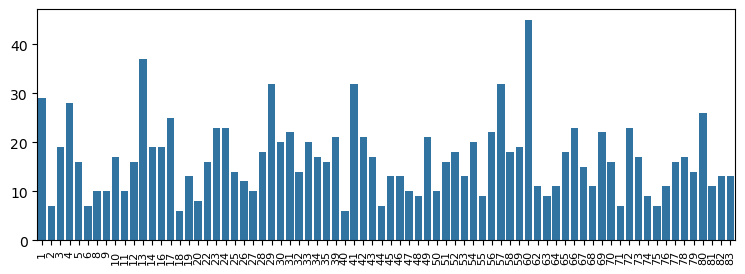

In [78]:
plt.figure(figsize=(9, 3))

sns.barplot({k:v for (k,v) in annot_nums})
plt.xticks(rotation=90,fontsize=8)
plt.show()

Minimum 0.47368421052631576 Mean 0.8471409194726501 Maximum 1.0


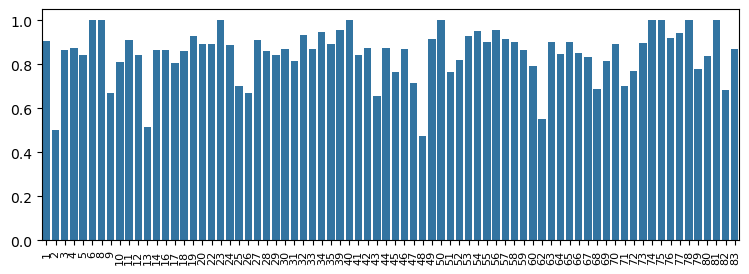

In [79]:
# As a proportion of the number of constructs as well ... 

theory_construct_lens = {pd.to_numeric(k):len(t.constructs) for k,t in theories.items()}

theory_proportion_annot = [(k,v/theory_construct_lens[k]) for k,v in annot_nums]

theory_proportion_annot

print("Minimum",min([v for (k,v) in theory_proportion_annot]),"Mean",statistics.mean([v for (k,v) in theory_proportion_annot]),"Maximum",max([v for (k,v) in theory_proportion_annot]))

plt.figure(figsize=(9, 3))
sns.barplot({k:v for (k,v) in theory_proportion_annot})
plt.xticks(rotation=90,fontsize=8)
plt.show()

#### Counts and interpretation of ontology annotation dataset

We look at the most common ontology annotations and visualise these 

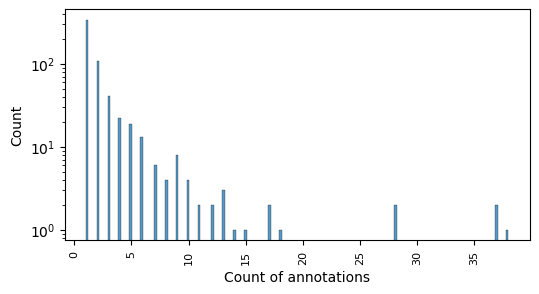

In [85]:
ontolabel_counts = {}

for (cid, count) in ontoid_counts.items():
    if isinstance(cid,str):
        ciri = onto.get_iri_for_id(cid)
        if ciri: 
            clabel = onto.get_annotation(ciri, RDFSLABEL)
            #print(cid,ciri,clabel,count)
            if clabel:
                ontolabel_counts[cid+" "+clabel]=count
            else: 
                ontolabel_counts[cid]=count


plt.figure(figsize=(6, 3))
sns.histplot(ontoid_counts.values ,log=True)
plt.xticks(rotation=90,fontsize=8)
plt.xlabel("Count of annotations")
plt.show()


In [108]:
ontocounts = {k:v for k,v in ontolabel_counts.items()}

#ontocounts
df_ontocounts = pd.DataFrame(list(ontocounts.items()), columns = ['Class', 'Count'])
df_ontocounts[['ID', 'label']] = df_ontocounts['Class'].str.split(' ', n=1, expand=True)
df_ontocounts = df_ontocounts.drop(columns=['Class'])

df_ontocounts.to_csv("classes_with_counts.csv", index = False)

df_ontocounts

,Count,ID,label
0,38,BCIO:006001,social environmental system
1,37,BCIO:036000,individual human behaviour
2,37,ENVO:01000254,environmental system
3,28,BCIO:006016,behavioural intention
4,28,BCIO:006154,self-efficacy belief for a behaviour
...,...,...,...
575,1,BCIO:050724,negotiating skill
576,1,BCIO:050640,emotional-relevance appraisal of possible cons...
577,1,BCIO:006070,mental plan for a behaviour
578,1,BCIO:050763,self-efficacy belief for a behaviour in the fa...


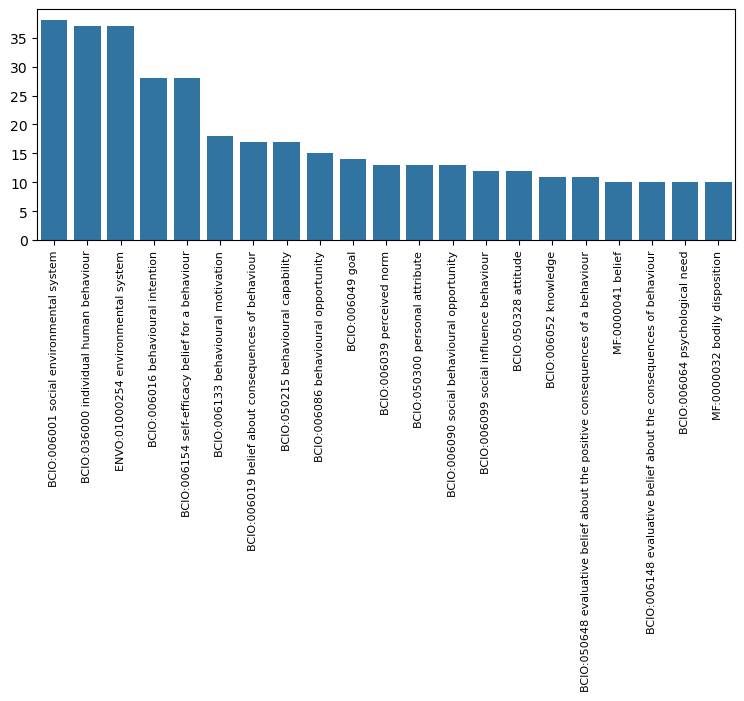

In [90]:
selected_ontocounts = {k:v for k,v in ontolabel_counts.items() if v>=10}

plt.figure(figsize=(9, 3))
sns.barplot(selected_ontocounts)
plt.xticks(rotation=90,fontsize=8)
plt.show()

In [82]:
selected_ontocounts

{'BCIO:006001 social environmental system': 38,
 'BCIO:036000 individual human behaviour': 37,
 'ENVO:01000254 environmental system': 37,
 'BCIO:006016 behavioural intention': 28,
 'BCIO:006154 self-efficacy belief for a behaviour': 28,
 'BCIO:006133 behavioural motivation': 18,
 'BCIO:006019 belief about consequences of behaviour': 17,
 'BCIO:050215 behavioural capability': 17,
 'BCIO:006086 behavioural opportunity': 15,
 'BCIO:006049 goal': 14,
 'BCIO:006039 perceived norm': 13,
 'BCIO:050300 personal attribute': 13,
 'BCIO:006090 social behavioural opportunity': 13,
 'BCIO:006099 social influence behaviour': 12,
 'BCIO:050328 attitude': 12,
 'BCIO:006052 knowledge': 11,
 'BCIO:050648 evaluative belief about the positive consequences of a behaviour': 11,
 'MF:0000041 belief': 10,
 'BCIO:006148 evaluative belief about the consequences of behaviour': 10,
 'BCIO:006064 psychological need': 10,
 'MF:0000032 bodily disposition': 10}


#### Interpret the annotations
We have loaded the annotation dataset, the ontology and the theory dataset. Now we would like to use the annotations to integrate across theories. 

- Statistics for overlaps between theories based on common annotations
- Percentage containment as was previously reported based on lexical matching. Now using ontology annotations. This answers the research question "which theories are comparable"? i.e. which theories partially overlap by referring to the same entities? 
- Maximal set of compatible and consistent entities and relationships as a single "mega-theory"
- Weighting of statements based on how often they appear in different theories, what are the most common statements? Mega-theory by consensus (voting)? 





#### Overlaps between theories based on common annotations

We calculate how many common annotations are shared pairwise between each combination of theories . This gives us a measure for how overlapping each pair of theories is. 


In [24]:
#print(theory_annotations)

theories_in_order = list(theory_annotations.keys())
theories_in_order.sort(key = lambda x: int(x))

theory_annot_overlaps = {}

for t1 in theories_in_order: 
    results_t1 = {}
    for t2 in theories_in_order: 
        onto_ids_t1 = theory_annotations[t1]
        onto_ids_t2 = theory_annotations[t2]
        overlaps = [value for value in onto_ids_t1 if value in onto_ids_t2]
        results_t1[t2]=overlaps
    theory_annot_overlaps[t1]=results_t1

print(theory_annot_overlaps)


{'1': {'1': ['BCIO:050590', 'ENVO:01000254', 'BCIO:050918', 'MF:0000032', 'BCIO:006016', 'BCIO:006042', 'BCIO:006059', 'MF:0000045', 'BCIO:050453', 'BCIO:006063', 'BCIO:050817', 'MFOEM:000053', 'BCIO:006034', 'BCIO:050617', 'BCIO:006096', 'BCIO:050592', 'BCIO:050564', 'BCIO:007023', 'BCIO:050886', 'BCIO:050328', 'BCIO:050818', 'MF:0000041', 'MFOEM:000001', 'BCIO:050708', 'BCIO:006038', 'BCIO:050775', 'BCIO:050942', 'BCIO:050917', 'ADDICTO:0001087'], '2': ['ENVO:01000254', 'BCIO:050328', 'MFOEM:000001'], '3': ['BCIO:006016', 'BCIO:006059'], '4': ['ENVO:01000254', 'BCIO:050328'], '5': ['ENVO:01000254'], '6': [], '8': [], '9': ['ENVO:01000254'], '10': ['ENVO:01000254', 'BCIO:050708'], '11': ['ENVO:01000254'], '12': [], '13': [], '14': ['ENVO:01000254', 'BCIO:006016', 'BCIO:006042', 'BCIO:050328'], '16': ['MF:0000032'], '17': ['BCIO:006096', 'BCIO:050818', 'MFOEM:000001'], '18': ['BCIO:006016'], '19': ['BCIO:050942'], '20': ['BCIO:006059'], '22': ['ENVO:01000254', 'MF:0000045', 'BCIO:00606

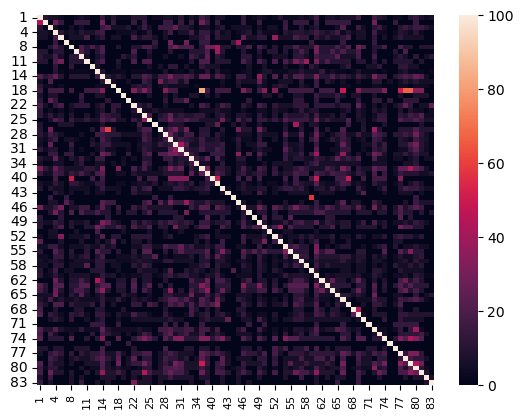

In [25]:
result_overlap_perc = []
annots_nums_dict = {str(k):v for (k,v) in annot_nums}

interesting_overlaps = {}

counter = 0
for t1 in theory_annot_overlaps:
    num_annots = annots_nums_dict[t1]
    if num_annots == 0: 
        print("Theory", t1, "has no annotations")
    else:
        result_overlap_perc.append([])
        for t2,overlaps in theory_annot_overlaps[t1].items():
            num_overlaps = len(overlaps)
            perc = num_overlaps / num_annots * 100
            result_overlap_perc[counter].append(perc)
            if perc < 100 and perc > 40:
                interesting_overlaps[t1+'-'+t2] = perc
        counter = counter+1

results_perc_overlap = pd.DataFrame(result_overlap_perc, theory_annot_overlaps.keys(),theory_annot_overlaps.keys())

results_perc_overlap


plt.figure()  # figsize=(9, 9)
sns.heatmap(results_perc_overlap)
plt.xticks(rotation=90,fontsize=8)
plt.show()

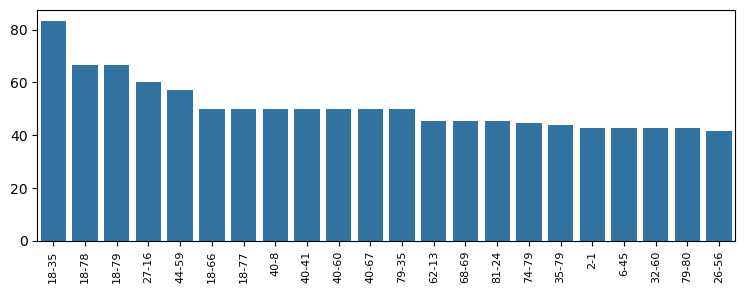

In [26]:
# Select just the higher ones...

interesting_overlaps_sorted = [ (k,v) for k,v in interesting_overlaps.items()]
interesting_overlaps_sorted.sort(reverse=True, key=lambda x: x[1])
interesting_overlaps_sorted

plt.figure(figsize=(9, 3))
sns.barplot({k:v for (k,v) in interesting_overlaps_sorted})
plt.xticks(rotation=90,fontsize=8)
plt.show()

#### Common Assertions

We collapse the theory assertions to triples using the ontology annotations rather than the construct labels. 
Then we look at how common the assertions are across different theories. 


In [27]:
annotated_triples = []

for theory_num, theory in theories.items():
    for triple in theory.triples:
        if triple.reified_rel is None: # Ignore the reified rels - too complex for this process now
            construct1 = triple.const1.name
            construct2 = triple.const2.name
            #print(f"Construct 1: '{construct1}', Construct 2: '{construct2}'")
            relationship = triple.relStr
            if 'relationship' not in construct1 and 'relationship' not in construct2:
                c1annots = resultdata.query(f"Theory_ID == {theory_num} and Construct.str.lower() == '{construct1.lower().replace("\n","").replace("'","")}'")[['Ontology_ID','Alt_Ontology_ID','Alt_Ontology_ID_2','Alt_Ontology_ID_3']]
                c2annots = resultdata.query(f"Theory_ID == {theory_num} and Construct.str.lower() == '{construct2.lower().replace("\n","").replace("'","")}'")[['Ontology_ID','Alt_Ontology_ID','Alt_Ontology_ID_2','Alt_Ontology_ID_3']]
                constr1_annots = [c for c in c1annots.values.flatten().tolist() if c]
                constr2_annots = [c for c in c2annots.values.flatten().tolist() if c]
                if len(constr1_annots)>0 and len(constr2_annots)>0: 
                    for annot1 in constr1_annots: 
                        for annot2 in constr2_annots:
                            if annot1 != annot2: 
                                a1iri = onto.get_iri_for_id(annot1)
                                a2iri = onto.get_iri_for_id(annot2)
                                a1label = onto.get_annotation(a1iri, RDFSLABEL) if a1iri else annot1
                                a2label = onto.get_annotation(a2iri, RDFSLABEL) if a2iri else annot2
                                #print("Theory",theory_num,"Construct1",construct1,"Annot1",annot1,"Rel",relationship,"Construct2",construct2,"Annot2",annot2)

                                annotated_triples.append( (annot1,a1label,relationship,annot2,a2label) )
                else:
                    print("Not including",theory_num,construct1,constr1_annots,construct2,constr2_annots)

#annotated_triples

Not including 12 Priority [] Differential association ['BCIO:036084']
Not including 13 Software information [] Innovation-evaluation information []
Not including 13 Innovation-evaluation information [] Uncertainty ['BCIO:050864']
Not including 13 Innovation clusters [] Adoption/rejection []
Not including 13 Characteristics of Innovations [] Adoption/rejection []
Not including 13 Communication Channels ['BCIO:050384'] Adoption/rejection []
Not including 13 Modelling ['BCIO:037024'] Adoption/rejection []
Not including 13 Innovation [] Adoption/rejection []
Not including 13 Innovation-decision ['BCIO:006116'] Time []
Not including 13 Innovativeness ['BCIO:050729'] Time []
Not including 13 Time [] Rate of adoption ['BCIO:050921']
Not including 13 System norms ['BCIO:006095'] Adoption/rejection []
Not including 13 Innovation-decision ['BCIO:006116'] Adoption/rejection []
Not including 13 Technology [] Innovation []
Not including 13 Software aspect [] Technology []
Not including 13 Hardware 

In [28]:
from collections import Counter

cnt = Counter(annotated_triples)

cnt

Counter({('BCIO:006001',
          'social environmental system',
          'Part of',
          'ENVO:01000254',
          'environmental system'): 10,
         ('BCIO:006001',
          'social environmental system',
          'Part of',
          'BCIO:006086',
          'behavioural opportunity'): 9,
         ('BFO:0000038',
          'one-dimensional temporal region',
          'Transitions to',
          'BCIO:050924',
          'behaviour non-intender'): 9,
         ('BCIO:050922',
          'behaviour enacter',
          'Transitions to',
          'BFO:0000038',
          'one-dimensional temporal region'): 7,
         ('BCIO:050671',
          'group evaluative behavioural norm',
          'Part of',
          'BCIO:006001',
          'social environmental system'): 6,
         ('BCIO:050922',
          'behaviour enacter',
          'Transitions to',
          'BCIO:050924',
          'behaviour non-intender'): 6,
         ('BCIO:006125',
          'operant conditioning',
  

In [29]:
triples_with_counts = []

for a,c in cnt.most_common():
    (a1,a1l,rel,a2,a2l) = a
    if isinstance(a1,str) and isinstance(a2,str):
        print(a1l, a1, rel, a2l, a2, c)
        triples_with_counts.append({"A1":a1,"A1Label":a1l,"Rel":rel,"A2":a2,"A2Label":a2l,"Count":c })
    else: 
        print(a1,rel,a2, "... some problem with IDs")

df_triple_counts = pd.DataFrame(triples_with_counts)
df_triple_counts.to_csv("triples_with_counts.csv",index=False)



social environmental system BCIO:006001 Part of environmental system ENVO:01000254 10
social environmental system BCIO:006001 Part of behavioural opportunity BCIO:006086 9
one-dimensional temporal region BFO:0000038 Transitions to behaviour non-intender BCIO:050924 9
behaviour enacter BCIO:050922 Transitions to one-dimensional temporal region BFO:0000038 7
group evaluative behavioural norm BCIO:050671 Part of social environmental system BCIO:006001 6
behaviour enacter BCIO:050922 Transitions to behaviour non-intender BCIO:050924 6
operant conditioning BCIO:006125 Type of intermittent schedule of reinforcement BCIO:050684 5
environmental system ENVO:01000254 Influences social influence behaviour BCIO:006099 4
behavioural decision BCIO:006048 Type of decision-making BCIO:006116 4
behavioural decision BCIO:006048 Part of social environmental system BCIO:006001 4
behavioural intention BCIO:006016 Influences individual human behaviour BCIO:036000 4
social influence behaviour BCIO:006099 Par

In [30]:
triples_mean = statistics.mean(df_triple_counts['Count'])
triples_min = min(df_triple_counts['Count'])
triples_max = max(df_triple_counts['Count'])
triples_sd = statistics.stdev(df_triple_counts['Count'])
triples_perc1 = statistics.mean(df_triple_counts['Count'] == 1)
print(triples_mean, triples_min, triples_max, triples_sd, triples_perc1)

1.1139021221307925 1 10 0.5220625265013286 0.9250757903854483


In [31]:
relationships = [sublist[2] for sublist in annotated_triples]


Counter(relationships)


Counter({'Influences': 973,
         'Part of': 862,
         'Type of': 358,
         'Influences (*)': 129,
         'Positively influences': 110,
         'Transitions to': 91,
         'Correlates with': 25,
         'Negatively influences': 17,
         'Influences (+)': 4,
         'May influence': 2,
         'Has attribute': 1})

#### Generate a diagram for an integrated set of theory expressions

We generate a diagram representing an "overarching" integrated set of theory expressions


In [32]:
! pip install networkx
! pip install pydot
! pip install graphviz

In [33]:
import networkx as nx

def wrap_if_needed(string_val):
    if ":" in string_val:
        return( f'"{string_val}"')
    return(string_val)

G=nx.DiGraph()

for (a1,a1l,rel,a2,a2l) in annotated_triples:
    if cnt[(a1,a1l,rel,a2,a2l)]>1 and isinstance(a1,str) and isinstance(a2,str):    
        if a1l is None or a2l is None:   # Exclude those for which we didn't yet find a label
            continue
        G.add_node(wrap_if_needed(a1l))
        G.add_node(wrap_if_needed(a2l))
        G.add_edge(wrap_if_needed(a1l),wrap_if_needed(a2l),label=rel,penwidth=str(cnt[(a1,a1l,rel,a2,a2l)]))
    
pdot = nx.drawing.nx_pydot.to_pydot(G)

for i, node in enumerate(pdot.get_nodes()):
    node_name = str(node).replace("\"","").replace(";","")
    node.set_shape('box')
    node.set_fontcolor('black')
    node.set_fillcolor('white')
    node.set_style('rounded, filled')
    node.set_color('black')

png_path = "merged-large.png"
pdot.write_png(png_path)

In [35]:
# A smaller file with just a selected set of nodes

important_nodes = ["MF:0000008","BCIO:036000","BCIO:006086","MFOEM:000195","BCIO:006016","BCIO:006099","ENVO:01000254","BCIO:006133","BCIO:006154","BCIO:006047"]

G=nx.DiGraph()

for (a1,a1l,rel,a2,a2l) in annotated_triples:
    if cnt[(a1,a1l,rel,a2,a2l)]>1 and isinstance(a1,str) and isinstance(a2,str):    
        if a1l is None or a2l is None:   # Exclude those for which we didn't yet find a label
            continue
        if a1 in important_nodes and a2 in important_nodes: 
            G.add_node(wrap_if_needed(a1l))
            G.add_node(wrap_if_needed(a2l))
            G.add_edge(wrap_if_needed(a1l),wrap_if_needed(a2l),label=rel,penwidth=str(cnt[(a1,a1l,rel,a2,a2l)]))
    
pdot = nx.drawing.nx_pydot.to_pydot(G)

for i, node in enumerate(pdot.get_nodes()):
    node_name = str(node).replace("\"","").replace(";","")
    node.set_shape('box')
    node.set_fontcolor('black')
    node.set_fillcolor('white')
    node.set_style('rounded, filled')
    node.set_color('black')

png_path = "merged-medium.png"
pdot.write_png(png_path)

### Using AI to integrate theories

- Training a knowledge graph encoder and then using it to predict the most likely links... can also visualise the embedding etc. See e.g. https://github.com/mims-harvard/graphml-tutorials/blob/master/04-link-prediction/link-prediction.ipynb 

In [33]:
# Build a graph with all three components: theories and ontology annotations and ontology
G=nx.DiGraph()

for theory_num, theory in theories.items():
    if theory_num and theory.name:
        G.add_node(theory_num,label=theory.name)
        
        for triple in theory.triples:
            if triple.reified_rel is None: # Ignore the reified rels - too complex for this process now
                construct1 = triple.const1.name
                construct2 = triple.const2.name
                if construct1 and construct2 and 'relationship' not in construct1 and 'relationship' not in construct2:
                    G.add_node(construct1,label=construct1)
                    G.add_edge(theory_num,construct1,label="has construct")
                    G.add_node(construct2,label=construct2)
                    G.add_edge(theory_num,construct2,label="has construct")
                    relationship = triple.relStr
                    if not relationship:
                        relationship = "relationship"
                    G.add_edge(construct1,construct2,label=relationship)
        
                    # Ontology annotations of constructs
                    c1annots = resultdata.query(f"Theory_ID == {theory_num} and Construct.str.lower() == '{construct1.lower().replace("'","").replace("\n","")}'")[['Ontology_ID','Alt_Ontology_ID','Alt_Ontology_ID_2','Alt_Ontology_ID_3']]
                    c2annots = resultdata.query(f"Theory_ID == {theory_num} and Construct.str.lower() == '{construct2.lower().replace("'","").replace("\n","")}'")[['Ontology_ID','Alt_Ontology_ID','Alt_Ontology_ID_2','Alt_Ontology_ID_3']]
                    constr1_annots = [c for c in c1annots.values.flatten().tolist() if c]
                    constr2_annots = [c for c in c2annots.values.flatten().tolist() if c]
                    for annot1 in constr1_annots:         
                        a1iri = onto.get_iri_for_id(annot1)
                        a1label = onto.get_annotation(a1iri, RDFSLABEL)  if a1iri else annot1
                        G.add_node(annot1,label=a1label)
                        G.add_edge(construct1,annot1,label="has annotation")
                    for annot2 in constr2_annots:
                        a2iri = onto.get_iri_for_id(annot2)
                        a2label = onto.get_annotation(a2iri, RDFSLABEL) if a2iri else annot2
                        G.add_node(annot2,label=a2label)
                        G.add_edge(construct2,annot2,label="has annotation")

# Ontology
for c in onto.get_classes():
    cid = onto.get_id_for_iri(c)
    if not cid: 
        cid = c
    clabel = onto.get_annotation(c, RDFSLABEL)
    if not clabel: 
        clabel = cid
    G.add_node(cid,label=clabel)
    for sc in onto.get_subclasses(c):
        scid = onto.get_id_for_iri(sc)
        if not scid: 
            scid = sc
        sclabel = onto.get_annotation(sc, RDFSLABEL)
        if not sclabel: 
            sclabel = scid
        G.add_node(scid,label=sclabel)
        G.add_edge(scid,cid,label="subClassOf")



In [34]:

nx.write_gml(G,'merged-theories.xml')

In [35]:
# PyKeen- embedding for knowledge graphs

! pip install pykeen

   ---------------------------------------- 0.0/730.3 kB ? eta -:--:--
   ---------------------------------------- 730.3/730.3 kB 7.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/212.5 MB ? eta -:--:--
   ---------------------------------------- 2.4/212.5 MB 11.2 MB/s eta 0:00:19
    --------------------------------------- 3.9/212.5 MB 9.4 MB/s eta 0:00:23
    --------------------------------------- 5.0/212.5 MB 8.2 MB/s eta 0:00:26
   - -------------------------------------- 6.3/212.5 MB 7.6 MB/s eta 0:00:28
   - -------------------------------------- 7.3/212.5 MB 7.3 MB/s eta 0:00:29
   - -------------------------------------- 8.9/212.5 MB 7.0 MB/s eta 0:00:30
   - -------------------------------------- 10.0/212.5 MB 6.8 MB/s eta 0:00:30
   -- ------------------------------------- 11.0/212.5 MB 6.6 MB/s eta 0:00:31
   -- ------------------------------------- 11.8/212.5 MB 6.2 MB/s eta 0:00:33
   -- ------------------------------------- 12.3/212.5 MB 6.0 MB/s eta 0

In [37]:
import pandas as pd

# Define the subjects, predicates, and objects - the entire graph structure
subjects =   []
predicates = []
objects =    []

for theory_num, theory in theories.items():
    for triple in theory.triples:
        if triple.reified_rel is None: # Ignore the reified rels - too complex for this process now
            construct1 = triple.const1.name
            construct2 = triple.const2.name
            if 'relationship' not in construct1 and 'relationship' not in construct2:
                subjects.append(theory_num+'---'+theory.name)
                predicates.append("has construct")
                objects.append(construct1)
                
                subjects.append(theory_num+'---'+theory.name)
                predicates.append("has construct")
                objects.append(construct2)
                
                subjects.append(construct1)
                predicates.append(triple.relStr)
                objects.append(construct2)
    
                # Ontology annotations of constructs
                c1annots = resultdata.query(f"Theory_ID == {theory_num} and Construct.str.lower() == '{construct1.lower().replace("'","").replace("\n","")}'")[['Ontology_ID','Alt_Ontology_ID','Alt_Ontology_ID_2','Alt_Ontology_ID_3']]
                c2annots = resultdata.query(f"Theory_ID == {theory_num} and Construct.str.lower() == '{construct2.lower().replace("'","").replace("\n","")}'")[['Ontology_ID','Alt_Ontology_ID','Alt_Ontology_ID_2','Alt_Ontology_ID_3']]
                constr1_annots = [c for c in c1annots.values.flatten().tolist() if c]
                constr2_annots = [c for c in c2annots.values.flatten().tolist() if c]
                for annot1 in constr1_annots:         
                    a1iri = onto.get_iri_for_id(annot1)
                    a1label = onto.get_annotation(a1iri, RDFSLABEL)  if a1iri else annot1

                    subjects.append(construct1)
                    predicates.append("has annotation")
                    objects.append(str(annot1)+'---'+str(a1label))
                    
                for annot2 in constr2_annots:
                    a2iri = onto.get_iri_for_id(annot2)
                    a2label = onto.get_annotation(a2iri, RDFSLABEL) if a2iri else annot2

                    subjects.append(construct2)
                    predicates.append("has annotation")
                    objects.append(str(annot2)+'---'+str(a2label))

# Ontology
for c in onto.get_classes():
    cid = onto.get_id_for_iri(c)
    if not cid: 
        cid = c

    for sc in onto.get_subclasses(c):
        scid = onto.get_id_for_iri(sc)
        if not scid: 
            scid = sc
        
        subjects.append(cid+'---'+onto.get_annotation(c, RDFSLABEL))
        predicates.append("subClassOf") # Todo add other relationships aside from the hierarhcy
        objects.append(scid+'---'+onto.get_annotation(sc, RDFSLABEL))  


# Create a dataframe
df = pd.DataFrame({'subject': subjects, 'predicate': predicates, 'object': objects})
df.to_csv('theorydataset.tsv', sep='\t', index=False, header=False)

df

,subject,predicate,object
0,1---Action Theory Model of Consumption,has construct,Somatic marker processes
1,1---Action Theory Model of Consumption,has construct,Anticipated emotions
2,Somatic marker processes,Influences,Anticipated emotions
3,Somatic marker processes,has annotation,BCIO:050564---affective attitude acquired thro...
4,Anticipated emotions,has annotation,BCIO:050590---belief about emotional consequen...
...,...,...,...
13262,BCIO:015324---father population statistic,subClassOf,BCIO:015325---percentage father population sta...
13263,BCIO:050364---providing psychological treatment,subClassOf,BCIO:050365---providing creative arts therapy
13264,ENVO:00000000---geographic feature,subClassOf,ENVO:00000002---anthropogenic geographic feature
13265,BCIO:015345---foster mother population statistic,subClassOf,BCIO:015346---percentage foster mother populat...


In [38]:
from pykeen.triples import TriplesFactory
from pykeen.nn import TextRepresentation
from pykeen.models import ERModel
from pykeen.datasets import Dataset


# Assuming your dataframe has columns 'subject', 'predicate', 'object'
triples_factory = TriplesFactory.from_labeled_triples(
    triples=df[['subject', 'predicate', 'object']].values,
)

dataset = Dataset.from_tf(triples_factory)

using automatically assigned random_state=1292013390


In [ ]:
#entity_representations = TextRepresentation.from_triples_factory(
#    triples_factory=dataset,
#    encoder="transformer",
#)
#result = pipeline(
#    dataset=dataset,
#    model=ERModel,
#    model_kwargs=dict(
#        interaction="ermlpe",
#        interaction_kwargs=dict(
#            embedding_dim=entity_representations.shape[0],
#        ),
#        entity_representations=entity_representations,
#        relation_representations_kwargs=dict(
#            shape=entity_representations.shape,
#        ),
#    ),
#    training_kwargs=dict(
#        num_epochs=1,
#    ),
#)
#model = result.model

In [39]:
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline

# Generate triples from the graph data
tf = TriplesFactory.from_labeled_triples(df.values)

# split triples into train and test
training, testing = tf.split([0.8, 0.2], random_state=42)

# generate embeddings using PyKEEN's pipeline method
result = pipeline(
        training=training,
        testing=testing,
        model = "TransR",
        model_kwargs=dict(embedding_dim=128),
        training_kwargs=dict(num_epochs=200),
        random_seed=42)

No cuda devices were available. The model runs on CPU
C:\Users\mabraun\AppData\Local\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/24.0 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/1.49k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 8.26s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

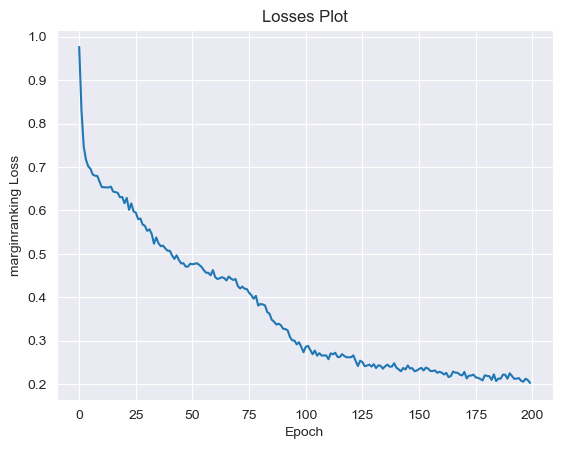

In [40]:
#plot loss
result.plot_losses()

In [41]:
import torch

# get entity labels from training set
entity_labels = training.entity_labeling.all_labels()
# convert entities to ids
entity_ids = torch.as_tensor(training.entities_to_ids(entity_labels))
# retrieve the embeddings using entity ids
entity_embeddings = result.model.entity_representations[0](indices=entity_ids)
# create a dictionary of entity labels and embeddings
entity_embeddings_dict = dict(zip(entity_labels, entity_embeddings.detach()))
#entity_embeddings_dict.values()

In [42]:
entity_embeds = []

for i, (k, v) in enumerate(entity_embeddings_dict.items()):
    entity_embeds.append({"Eindex":i,"Elabel":k,"Embedding":v.numpy()})

df_entity_embeddings = pd.DataFrame(entity_embeds)
df_entity_embeddings

,Eindex,Elabel,Embedding
0,0,1---Action Theory Model of Consumption,"[0.00073166774, 0.0049198037, -0.0101209, -0.0..."
1,1,10---Containment Theory May 2020,"[0.0120317405, -0.0012051872, -0.010702705, -0..."
2,2,11---Control Theory,"[0.005901439, 0.007174182, -0.0065826317, 0.00..."
3,3,12---Differential Association Theory,"[0.01352992, 0.008384072, -0.022429677, -0.001..."
4,4,13---Diffusion of Innovations,"[0.0069389683, 0.0034088427, -0.013247193, 0.0..."
...,...,...,...
3823,3823,Work / labour,"[0.0016083994, 0.007920478, 0.0013492822, 9.68..."
3824,3824,Work attitudes,"[0.007339235, -0.019538982, -0.00025939825, -0..."
3825,3825,Work environment features,"[0.0044172616, -0.009369556, -0.005695282, 0.0..."
3826,3826,Work events,"[0.001530001, 0.0018308106, -0.0024702814, 0.0..."


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
entity_embeddings = [ d for d in df_entity_embeddings['Embedding'] ]
#print(entity_embeddings)
m = pca.fit(entity_embeddings)

eu = m.transform(entity_embeddings)
eu

array([[-0.00461365, -0.01812415],
       [ 0.01128504,  0.00633122],
       [ 0.02890661,  0.02160067],
       ...,
       [-0.04097933,  0.04955276],
       [-0.06875806,  0.01993506],
       [-0.05298127,  0.01538891]])

(-0.1, 0.1)

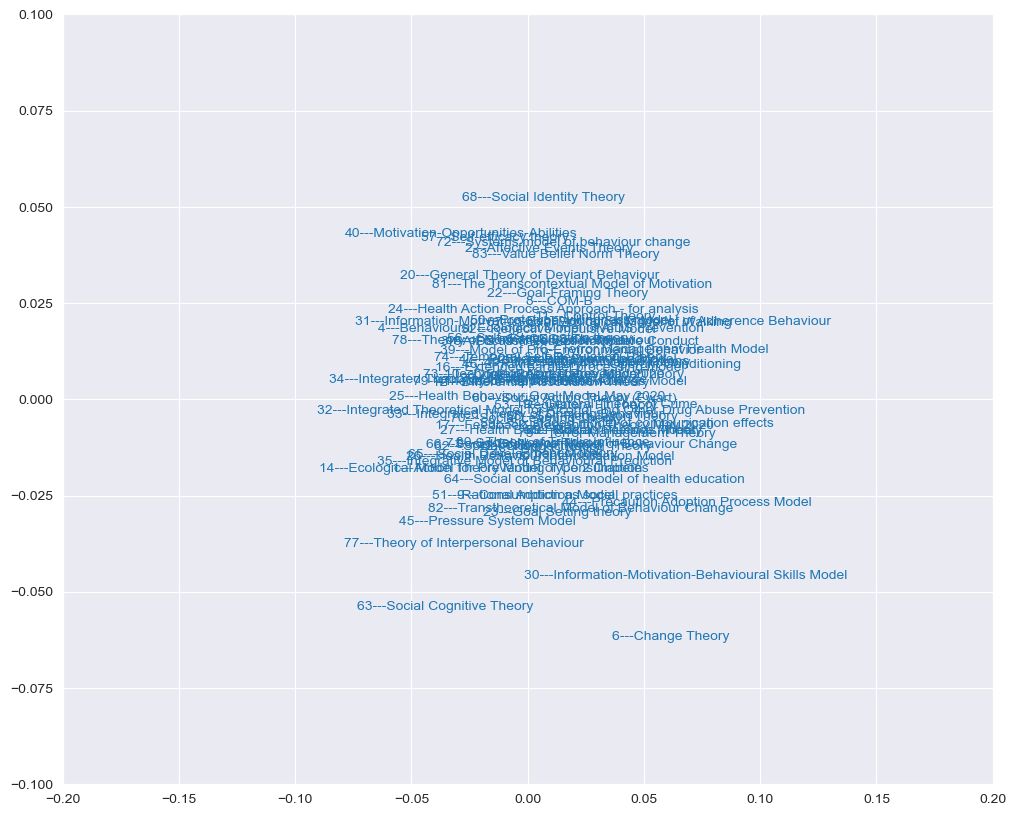

In [44]:
# plt.plot(eu[:, 0], eu[:, 1],'.b')

# Plot theories: 

plt.figure(figsize=(12, 10))

for index,row in df_entity_embeddings.iterrows():
    entity_num = row['Eindex']
    entity = row['Elabel']
    if entity_num < 76:
        plt.annotate(
            text=entity,
            xy=(eu[entity_num, 0], eu[entity_num, 1]),
            color="tab:blue",
            ha="center", va="center"
        )

plt.xlim([-.2, .2])
plt.ylim([-.1, .1])

(-0.1, 0.1)

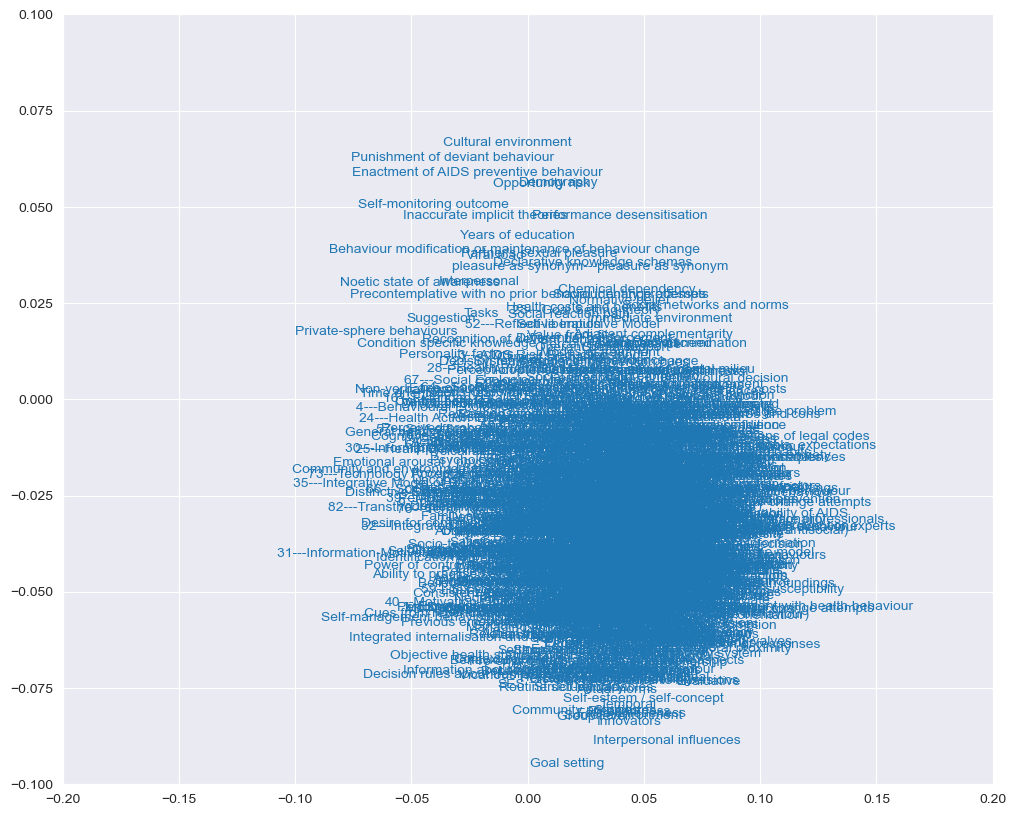

In [64]:
# Plot constructs

plt.figure(figsize=(12, 10))

for index,row in df_entity_embeddings.iterrows():
    entity_num = row['Eindex']
    entity = row['Elabel']
    if ":" not in entity and "Theory" not in entity:
        plt.annotate(
            text=entity,
            xy=(eu[entity_num, 0], eu[entity_num, 1]),
            color="tab:blue",
            ha="center", va="center"
        )

plt.xlim([-.2, .2])
plt.ylim([-.1, .1])


#    elif ":" in id_to_entity[entity]:
#        plt.annotate(
#            text=id_to_entity[entity][0:10],
#            xy=(eu[i, 0], eu[i, 1]),
#            color="tab:green",
#            ha="center", va="center"
#        )
#    else: 
#        plt.annotate(
#            text=id_to_entity[entity][0:10],
#            xy=(eu[i, 0], eu[i, 1]),
#            color="tab:grey",
#            ha="center", va="center"
#        )
#    
### NEED A DYNAMIC INTERACTIVE VISUALISATION SO WE CAN CHOOSE CONSTRUCTS ETC AND VISUALISE THEM 
### ALSO SEE THE DIFFERENCES IN EMBEDDING SPACE 

In [45]:
# get relation labels from training set
relation_labels = training.relation_labeling.all_labels()
# convert relations to ids
relation_ids = torch.as_tensor(training.relations_to_ids(relation_labels))
# retrieve the embeddings using relation ids
relation_embeddings = result.model.relation_representations[0](indices=relation_ids)
# create a dictionary of relation labels and embeddings
relation_embeddings_dict = dict(zip(relation_labels, relation_embeddings.detach().numpy()))

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage([d for d in df_entity_embeddings['Embedding'].head(76)], method='ward')

In [47]:
len(Z)

75

0              1---Action Theory Model of Consumption
1                    10---Containment Theory May 2020
2                                 11---Control Theory
3                12---Differential Association Theory
4                       13---Diffusion of Innovations
                           ...                       
71                   80---Theory of Triadic Influence
72       81---The Transcontextual Model of Motivation
73    82---Transtheoretical Model of Behaviour Change
74                      83---Value Belief Norm Theory
75                9---Consumption as social practices
Name: Elabel, Length: 76, dtype: object


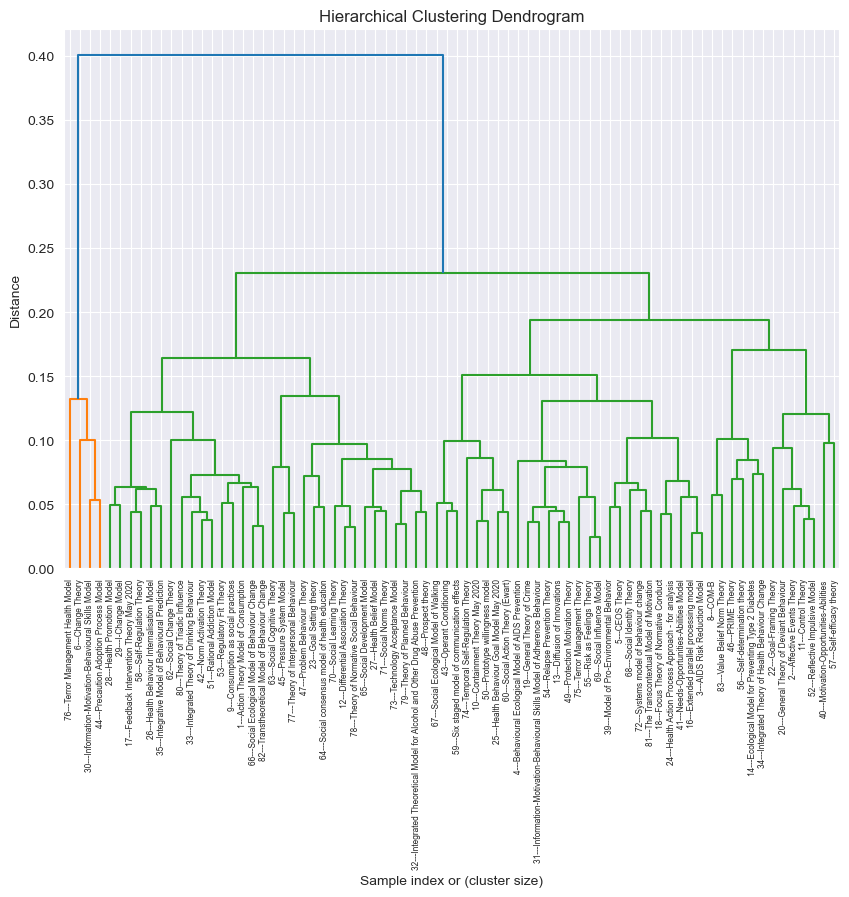

In [48]:
import numpy as np
import matplotlib.pyplot as plt
# Plot the dendrogram
print(df_entity_embeddings['Elabel'].head(76))

plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
dendrogram(Z, labels=[l for l in df_entity_embeddings['Elabel'].head(76)])
plt.show()

### Can we use the method of knowledge graph link prediction to predict relationships? 

Not for theory integration manuscript (and below)
As a way to test the integrated theories

In [49]:
from pykeen import predict

# tail prediction
predict.predict_target(model=result.model,
                       head="mexico",
                       relation="neighbor",
                       triples_factory=result.training).df.head(20)

KeyError: 'mexico'

In [50]:
from pykeen.evaluation import RankBasedEvaluator

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

NameError: name 'validation' is not defined

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(12, 10))
pca = PCA(n_components=2)
entity_embeddings = result.model.entity_representations[0](indices=None).detach().numpy()
m = pca.fit(entity_embeddings)

eu = m.transform(entity_embeddings)
# plt.plot(eu[:, 0], eu[:, 1],'.b')
for i, entity in enumerate(triples_factory.entity_id_to_label):
    if "Theory" in id_to_entity[entity]:
        plt.annotate(
            text=id_to_entity[entity][0:10],
            xy=(eu[i, 0], eu[i, 1]),
            color="tab:blue",
            ha="center", va="center"
        )
    elif ":" in id_to_entity[entity]:
        plt.annotate(
            text=id_to_entity[entity][0:10],
            xy=(eu[i, 0], eu[i, 1]),
            color="tab:green",
            ha="center", va="center"
        )
    else: 
        plt.annotate(
            text=id_to_entity[entity][0:10],
            xy=(eu[i, 0], eu[i, 1]),
            color="tab:grey",
            ha="center", va="center"
        )
    


#relation_embeddings = model.relation_representations[0](indices=None).detach().numpy()
#ru = pca.transform(relation_embeddings)
#for i, relation in enumerate(triples_factory.relation_id_to_label):
#    plt.annotate(
#        text=id_to_relation[relation],
#        xy=(0,0), xytext=(ru[i, 0], ru[i, 1]),
#        arrowprops=dict(
#            arrowstyle="<-",
#            color="tab:red",
#            shrinkA=5,
#            shrinkB=5,
#            patchA=None,
#            patchB=None,
#            connectionstyle="arc3,rad=0."
#        )
#    )

plt.xlim([-2, 2])
plt.ylim([-2, 2])

NameError: name 'id_to_entity' is not defined

<Figure size 1200x1000 with 0 Axes>

### Using the class hierarchy to integrate theories

We aim to use the ontology class hierarchy to expand the annotations and use the expanded annotations to integrate across the theories to form an overarching "integrated" theory. 

Some ideas: 
- Looking for contradictions using a logical reasoner (but do we have sufficient disjointness axioms to use for this?)
- Some kind of enrichment analysis algorithm?